In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from unsupervised_bias_detection.cluster import BiasAwareHierarchicalKModes

In [20]:
pip show unsupervised_bias_detection

Name: unsupervised-bias-detection
Version: 0.2.6
Summary: package for unsupervised bias detection
Home-page: 
Author: NGO Algorithm Audit
Author-email: 
License: EUPL-1.2 license
Location: /opt/homebrew/lib/python3.11/site-packages
Requires: kmodes, numpy, scikit-learn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


#### A. Load data and data preparation

##### A.1 Load data

In [2]:
# Load the COMPAS dataset
file_path = "./compas-scores-two-years.csv"  # Replace with the actual path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


##### 0.2 Data cleaning

In [3]:
# Check for missing values
print(df.isnull().sum())

# Select relevant columns
columns_of_interest = ["age_cat", "sex", "race", "c_charge_degree", "is_recid", "score_text"]
filtered_df = df[columns_of_interest]

# Drop rows with missing values
filtered_df = filtered_df.dropna()

filtered_df.head()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,Greater than 45,Male,Other,F,0,Low
1,25 - 45,Male,African-American,F,1,Low
2,Less than 25,Male,African-American,F,1,Low
3,Less than 25,Male,African-American,F,0,High
4,25 - 45,Male,Other,F,0,Low


**UI text #1** (only demo)

**Information about demo dataset**

As a demo, the [COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) dataset](https://github.com/propublica/compas-analysis/tree/master) is loaded. The dataset contains features about criminal defendants and their risk of recidivism as predicted by the COMPAS algorithm. It includes demographic details such as age, sex, and race, as well as criminal history, charge details, and the predicted risk label. This dataset is as a benchmark for studying algorithmic discrimination. A description of all variables can be found in the table below.

**Variable description**
+-----------------+-----------------------------------+----------------------------------------+
| Variable name   | Description                       | Values                                 |
+-----------------+-----------------------------------+----------------------------------------+
| age_cat         | Age category                      | Less than 25, 25-45, Greater than 45   |
+-----------------+-----------------------------------+----------------------------------------+
| sex             | Sex                               | Male, Female                           |
+-----------------+-----------------------------------+----------------------------------------+
| race            | Race                              | African-American, Asian, Caucasian,    |
|                 |                                   | Hispanic, Native American, Other       |
+-----------------+-----------------------------------+----------------------------------------+
| c_charge_degree | Severity level of the criminal    | M: Misdemeanor – Less severe offenses  |
|                 | charge                            | F: Felony – More serious crimes        |
+-----------------+-----------------------------------+----------------------------------------+
| is_recid        | If defendant reoffended           | 0: No, 1: Yes                          |
+-----------------+-----------------------------------+----------------------------------------+
| score_text      | Predicted risk label of defendant | 0: Not high risk, 1: High risk         |
+-----------------+-----------------------------------+----------------------------------------+
| False positive  | Defendent did not reoffend, while | 0: not FP, 1: FP                       |
| (FP)            | being predicted as high risk      |                                        |
+-----------------+-----------------------------------+----------------------------------------+



**UI text #2**

In this example, we analyze which group is most adversely affected by the risk prediction algorithm. We do this by applying the clustering algorithm on the dataset previewed below. The column `false positive` (FP) represents cases where a defendant was predicted to reoffended but in reality didn't. A preview of the data can be found below.

**0. Preview of data**

[below table with top-5 rows]

In [4]:
# map bias metric (score text) to binary values
filtered_df["score_text"] = filtered_df["score_text"].map(lambda x: 1 if x == "High" else 0)
filtered_df["is_recid"] = filtered_df["is_recid"].astype("category")

# Display the updated dataframe
filtered_df.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,Greater than 45,Male,Other,F,0,0
1,25 - 45,Male,African-American,F,1,0
2,Less than 25,Male,African-American,F,1,0
3,Less than 25,Male,African-American,F,0,1
4,25 - 45,Male,Other,F,0,0


In [5]:
# Apply OrdinalEncoder to the categorical columns
encoder = OrdinalEncoder()
filtered_df[filtered_df.columns] = encoder.fit_transform(filtered_df)

# Display the transformed DataFrame
filtered_df.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,1.0,1.0,5.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0
2,2.0,1.0,0.0,0.0,1.0,0.0
3,2.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,5.0,0.0,0.0,0.0


In [6]:
filtered_df.dtypes

age_cat            float64
sex                float64
race               float64
c_charge_degree    float64
is_recid           float64
score_text         float64
dtype: object

##### A.3 Explanatory data analysis

In [7]:
# for this notebook only
dim = filtered_df.shape
print(dim)
n = dim[0]

(7214, 6)


In [8]:
# Example: Group by race to see recidivism rates (for this notebook only)
recidivism_rates = df.groupby("race")["two_year_recid"].mean()
print(recidivism_rates)

race
African-American    0.514340
Asian               0.281250
Caucasian           0.393643
Hispanic            0.364207
Native American     0.555556
Other               0.352785
Name: two_year_recid, dtype: float64


**UI text #3**

**1. Paramters selected for clustering**

- Number of iterations: {n_iter}
- Minimal cluster size: {n_iter}
- Bias metric: {bias_metric}
- Data type: [TO DO]

#### B. Split dataset in train and test set

In [9]:
# split the data into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
X_train = train_df.drop(columns=["score_text"])
y_train = train_df["score_text"]

# remove the bias metric from the test set to prevent issues with decoding
X_test = test_df.drop(columns=["score_text"])

# display the shapes of the resulting datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (5771, 6)
Testing set shape: (1443, 6)


**UI text #4**

**2. Splitting dataset**

To reduce the possibility that the clustering method detects noise, the dataset is split in a train (80%) and test dataset (20%). The clustering method is first fitted on the train dataset. Then, the presence of statistically significant bias in deviating clusters is evaluated using the test dataset.

- Training set shape: {train_df.shape[0]}
- Testing set shape: {test_df.shape[0]}

#### C. Fitting HBAC - kmodes

In [10]:
# n_iter and min_cluster can be specified by the user in the web app
hbac = BiasAwareHierarchicalKModes(bahc_max_iter=20, bahc_min_cluster_size=n*0.05)
hbac.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but BiasAwareHierarchicalClustering was fitted without feature names
  warnings.warn(


BiasAwareHierarchicalKModes(bahc_max_iter=20,
                            bahc_min_cluster_size=360.70000000000005)

In [11]:
# number of clusters
hbac.n_clusters_

4

In [12]:
# bias metric scores
hbac.scores_

array([ 0.06562301,  0.02851334, -0.00819492, -0.20764978])

In [13]:
num_zeros = np.sum(hbac.labels_ == 0)
print(f"Number of datapoints in most deviating cluster: {num_zeros}/{train_df.shape[0]}")

Number of datapoints in most deviating cluster: 1145/5771


**UI text #5**

**3. Clustering results**

- Number of clusters detected: {hbac.n_clusters_}
- Number of datapoints in most deviating cluster: {num_zeros}/{train_df.shape[0]}

In [14]:
# assign cluster label to the test set, based on results from the training set
y_test = hbac.predict(X_test.to_numpy())
y_test

array([1, 1, 0, ..., 1, 2, 0], dtype=uint32)

In [15]:
# decode X_test using the encoder
decoded_X_test = test_df.copy()
decoded_X_test = encoder.inverse_transform(test_df)

# display the decoded DataFrame
decoded_X_test = pd.DataFrame(decoded_X_test, columns=test_df.columns)
decoded_X_test

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,Greater than 45,Male,Caucasian,F,0,0
1,25 - 45,Male,African-American,M,0,0
2,Greater than 45,Male,African-American,M,1,0
3,Less than 25,Male,African-American,F,1,1
4,25 - 45,Female,Other,M,0,0
...,...,...,...,...,...,...
1438,Greater than 45,Male,African-American,M,1,0
1439,25 - 45,Female,Caucasian,F,0,0
1440,25 - 45,Male,Caucasian,F,0,0
1441,25 - 45,Male,Caucasian,F,1,0


In [16]:
decoded_X_test["cluster_label"] = y_test
decoded_X_test.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text,cluster_label
0,Greater than 45,Male,Caucasian,F,0,0,1
1,25 - 45,Male,African-American,M,0,0,1
2,Greater than 45,Male,African-American,M,1,0,0
3,Less than 25,Male,African-American,F,1,1,3
4,25 - 45,Female,Other,M,0,0,1


In [17]:
# Calculate the high risk rate for each cluster label
high_risk_rates = decoded_X_test.groupby("cluster_label")["score_text"].mean()

# Display the high risk rates
print(high_risk_rates)

cluster_label
0    0.156934
1    0.201835
2    0.166667
3    0.356589
Name: score_text, dtype: object


In [18]:
# Count of high risk labels for each cluster
high_risk_counts = decoded_X_test.groupby("cluster_label")["score_text"].sum()

# Total counts for each cluster
total_counts = decoded_X_test["cluster_label"].value_counts()

# Perform the z-test
count = [high_risk_counts[0], high_risk_counts[1]]
nobs = [total_counts[0], total_counts[1]]
stat, p_value = proportions_ztest(count, nobs)

print(f"Z-statistic: {stat}")
print(f"P-value: {p_value}")

Z-statistic: -1.6489809000432267
P-value: 0.09915154773426922


**UI text #7**

**4. Visualization**
...

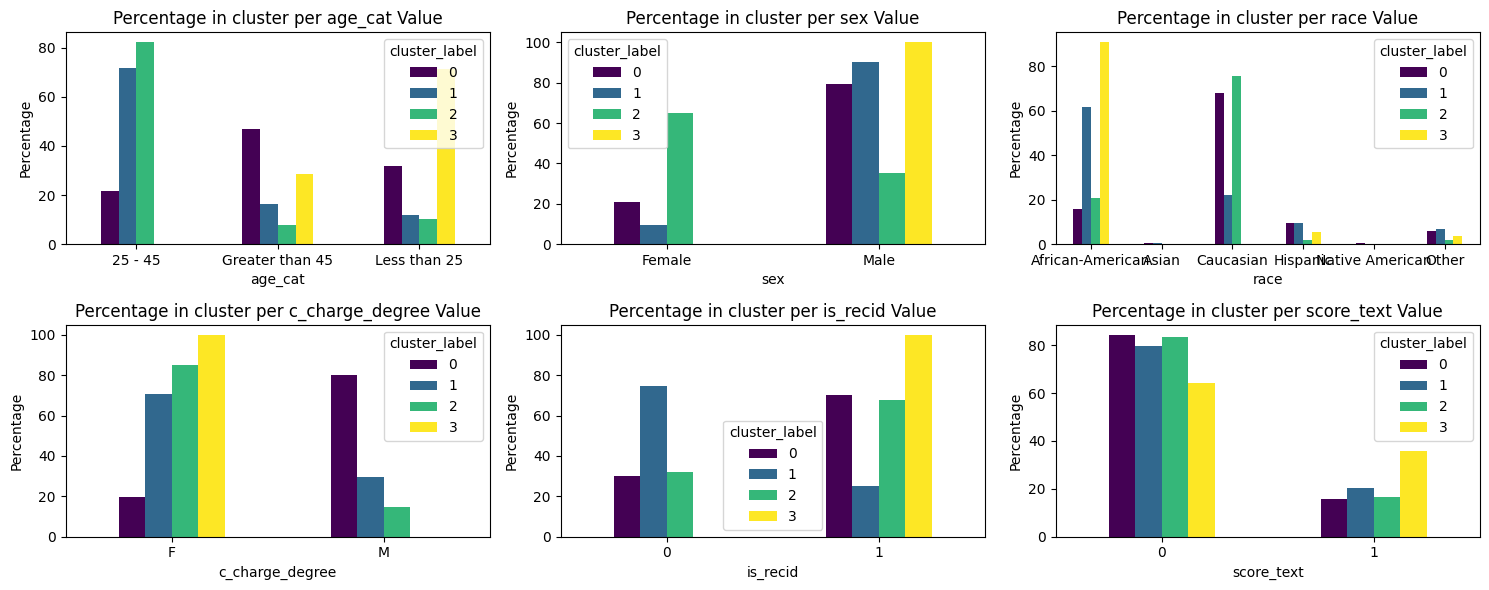

In [19]:
# Group by cluster_label and count the occurrences
cluster_counts = decoded_X_test["cluster_label"].value_counts()

# Create subplots for each column
columns_to_analyze = decoded_X_test.columns[:-1]  # Exclude 'cluster_label' column
rows = (len(columns_to_analyze) + 2) // 3  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, min(len(columns_to_analyze), 3), figsize=(15, 3 * rows), squeeze=False)
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, column in enumerate(columns_to_analyze):
    # Group by cluster_label and the column, then calculate percentages
    grouped_data = decoded_X_test.groupby(["cluster_label", column]).size().unstack(fill_value=0)
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
    
    # Plot the percentage data
    percentages.T.plot(kind="bar", ax=axes[i], colormap="viridis")
    axes[i].set_title(f"Percentage in cluster per {column} Value")
    axes[i].set_ylabel("Percentage")
    axes[i].set_xticklabels(percentages.T.index, rotation=0)

plt.tight_layout()
plt.show()